# **05 - Model Training and Evaluation**

## Objectives
* Fit, train, and evaluate a machine learning regression model to predict the price of inherited houses.
* Regression is chosen because it predicts continuous numerical values, making it ideal for estimating house prices.
* Ensure the model is robust and generalizes well to unseen data.
* This step directly addresses **Business Requirement 2** by building a model capable of predicting house sale prices.


## Inputs
* Cleaned dataset: `outputs/cleaned/house_prices_cleaned.parquet`
    * This dataset has been cleaned and prepared during the feature engineering step, ensuring it is ready for model training.
    * It includes all relevant features and the target variable (`SalePrice`), which is the house sale price to be predicted.


## Outputs
* ML Regression Pipeline: `outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl`
    * The final trained pipeline, saved as a pickle file for deployment and future use.
* Feature Importance Plot: `outputs/ml_pipeline/predict_price/v1/feature_importance.png`
    * Visualizes the most important features, helping to understand the model's decision-making process.
* Train Set (feature and target): 
    * `outputs/ml_pipeline/predict_price/v1/X_train.csv`
    * `outputs/ml_pipeline/predict_price/v1/y_train.csv`
    * These files store the training data used to fit the model.
* Test Set (feature and target): 
    * `outputs/ml_pipeline/predict_price/v1/X_test.csv`
    * `outputs/ml_pipeline/predict_price/v1/y_test.csv`
    * These files store the test data used to evaluate the model's performance.
* These outputs will be used for deployment and to create a dashboard for visualizing predictions and feature importance.


## Additional Comments
* The feature importance plot generated in this notebook will also address **Business Requirement 1** by showing how house attributes correlate with sale prices.


---

## Change Working Directory

Ensure the working directory is set to the project root for consistent file paths. This ensures that all file paths work correctly, regardless of where the notebook is executed.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'd:\\Projects\\milestone-project-heritage-housing-issues\\jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'd:\\Projects\\milestone-project-heritage-housing-issues'

---

## 1. Load Dataset and Create New ML Directory

### 1.1 Import and Load Dataset

In [4]:
# Import Numpy for numerical operations
import numpy as np

# Import Pandas for data manipulation
import pandas as pd

# Create DataFrame of cleaned dataset of house prices
df = pd.read_parquet("outputs/datasets/cleaned/house_prices_cleaned.parquet")

# Display the amount of rows/columns and first five rows of the DataFrame
print(df.shape)
df.head(5)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


### 1.2 Create New Directory for ML Outputs

To ensure proper version control and organization of outputs, this code creates a directory structure where all files related to the machine learning pipeline will be saved. By defining a `version` variable, it becomes easy to manage multiple iterations of the pipeline. This approach simplifies version management and ensures that outputs from different versions are stored separately, making it easier to track changes and updates.

In [5]:
# Import the joblib library for saving and loading Python objects (e.g., models, pipelines)
import joblib

# Define the version of the model artifacts
version = 'v1'

# Define the file path where the model artifacts will be saved, including the version
file_path = f'outputs/ml_pipeline/predict_price/{version}/'

# Create the directory for storing model artifacts
# This ensures that all outputs (e.g., trained models, plots) are saved in a structured and versioned folder
try:
    os.makedirs(name=file_path, exist_ok=True)  # Avoid errors if the directory already exists
    print(f"Directory created: {file_path}")
except Exception as e:
    # Handle any errors that occur during directory creation
    print(f"Error creating directory: {e}")

Directory created: outputs/ml_pipeline/predict_price/v1/


---

## 2. ML Pipeline: Regressor

Construction of a machine learning regression pipeline that integrates feature engineering, data preprocessing, and model training. The pipeline is modular, making it easy to adjust or replace individual steps as needed.

### 2.1 Imports Libraries 

In [6]:
# Pipeline
from sklearn.pipeline import Pipeline

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data Splitting
from sklearn.model_selection import train_test_split

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Regression Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from xgboost import XGBRegressor

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Evaluation Metrics
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

### 2.2 Create ML Pipeline

In [7]:
# Define the function to create the pipeline
def CreatePipeline(model):
    """
    Function to create a machine learning pipeline for regression tasks.
    Includes data cleaning, feature engineering, scaling, and model training.
    """
    pipeline_base = Pipeline([
        # 1. Handle missing values
        # Replace missing values in numerical features with the mean or median
        ('mean', MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage',
                                                     'TotalBsmtSF'])),

        ('median', MeanMedianImputer(imputation_method='median',
                                            variables=['MasVnrArea',
                                                       '2ndFlrSF'])),

        ('categorical', CategoricalImputer(imputation_method='missing',
                                                  variables=['GarageFinish',
                                                             'BsmtExposure',
                                                             'BsmtFinType1',
                                                             'KitchenQual'])),
        
        # 2. Encode categorical variables
        ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary',
                                          variables=['GarageFinish',
                                                     'BsmtExposure',
                                                     'BsmtFinType1',
                                                     'KitchenQual'])),
        
        # 3. Transform numerical variables
        ('lt', vt.LogTransformer(variables=['GrLivArea', 'LotArea'])),
        ('pt', vt.PowerTransformer(variables=['GarageArea', 'OpenPorchSF', 'TotalBsmtSF'])),
        
        # 4. Handle outliers
        ('winsorize', Winsorizer(capping_method='iqr', tail='both', fold=1.5, 
                                 variables=['LotFrontage', 'GarageArea', 'TotalBsmtSF'])),
        
        # 5. Remove highly correlated features
        ('correlation_selection', SmartCorrelatedSelection(method='spearman', 
                                                           threshold=0.8, 
                                                           selection_method='variance')),
        
        # 6. Scale numerical features
        ('scale_features', StandardScaler()),
        
        # 7. Select important features
        ('feature_selection', SelectFromModel(model)),
        
        # 8. Train the model
        ('model', model)
    ])
    
    return pipeline_base

## 3: Model Training
Training the machine learning regression model using the create pipeline. The training process involves fitting the pipeline to the training data and preparing it for evaluation.

### 3.1 Custom Class for Hyperparameter Tuning

*This code was inspired by Modeling and Evaluation in Walkthrough Project 2: Churnometer.*

We create the `HyperparameterTuning` class as a custom solution for performing hyperparameter tuning using `GridSearchCV`. It is designed to handle multiple models and their respective parameter grids, making it easy to optimize and compare different models.

In [8]:
# Define the class for hyperparameter tuning
class HyperparameterTuning:
    """
    Custom class for hyperparameter tuning using GridSearchCV.
    Supports multiple models and parameter grids, making it easy to optimize and compare different models.
    """
    def __init__(self, models, params):
        # Initialize with a dictionary of models and their corresponding parameter grids
        self.models = models  
        self.params = params 
        self.keys = models.keys()
        self.grid_searches = {}  

    # Perform hyperparameter tuning
    def fit(self, X, y, n_jobs, cv=5, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = CreatePipeline(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    # Summarize score
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})
        
        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))
            
            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append(row(k, s, p))

        # Creates a DataFrame with results
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        # Define columns for DataFrame
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### 3.2 Split Data into Train and Test Set

We split the dataset into a training set (80%) and a test set (20%). The training set is used to train the model, while the test set is used to evaluate its performance on unseen data.

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],               
    test_size=0.2,  # 20% of the data for testing
    random_state=42,                    
    shuffle=True                         
)

# Display the amount of rows/columns for training and testing sets
print(f"*** Training Set: {X_train.shape}, {y_train.shape}")
print(f"*** Test Set: {X_test.shape}, {y_test.shape}")

*** Training Set: (1168, 21), (1168,)
*** Test Set: (292, 21), (292,)


### 3.3 GridSearchCV

#### 3.3.1 Quick Search To Find the Most Suitable Algorithm
We perform a quick search to identify the most promising algorithms and their general performance. This allows us to focus our extensive hyperparameter tuning on the best-performing models, saving time and computational resources.

##### 3.3.1.1 Create Model

In [10]:
# Define the models to be trained
models_quick = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
}

# Define the hyperparameter grids for each model
params_quick = {
    "LinearRegression": {},

    "DecisionTreeRegressor": {'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "RandomForestRegressor": {'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "ExtraTreesRegressor": {'model__n_estimators': [100,50,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },

    "AdaBoostRegressor": {'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
        },

    "GradientBoostingRegressor": {'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
        },

    "XGBRegressor": {'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
        },
}

In [11]:
# Import warnings
import warnings

# Ignorera FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize quick search for hyperparameter tuning where predefined models and parameter grids are used
search = HyperparameterTuning(models=models_quick, params=params_quick)

# Optimizing training data with R² (R-squared) as evaluation metric and 5-fold cross-validation
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


##### 3.3.1.2 Quick Search Results

In [12]:
# Create and display table to summarize results of quick hyperparameter search
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
125,ExtraTreesRegressor,0.759327,0.786298,0.815002,0.018258,15,NaN,1,50,50,NaN,NaN,NaN
101,ExtraTreesRegressor,0.759327,0.786298,0.815002,0.018258,None,NaN,1,50,50,NaN,NaN,NaN
102,ExtraTreesRegressor,0.758642,0.784584,0.81436,0.018244,None,NaN,1,50,150,NaN,NaN,NaN
126,ExtraTreesRegressor,0.758641,0.784543,0.814295,0.018236,15,NaN,1,50,150,NaN,NaN,NaN
100,ExtraTreesRegressor,0.759868,0.784465,0.813479,0.017663,None,NaN,1,50,100,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,XGBRegressor,-6.22636,-5.309452,-4.026019,0.86777,3,NaN,NaN,NaN,30,0.001,NaN,0.1
409,XGBRegressor,-6.232797,-5.309706,-4.024739,0.868919,15,NaN,NaN,NaN,30,0.001,NaN,0
430,XGBRegressor,-6.232797,-5.309706,-4.024739,0.868919,None,NaN,NaN,NaN,30,0.001,NaN,0.1
436,XGBRegressor,-6.232797,-5.309706,-4.024739,0.868919,15,NaN,NaN,NaN,30,0.001,NaN,0.1


#### 3.3.2 Perform a comprehensive search for the most promising model

*This code was inspired by Modeling and Evaluation in Walkthrough Project 2: Churnometer.*

##### 3.3.2.1 Create Model for Extensive Hyperparameter Tuning

In [13]:
# Define the models to be searched
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

# Define the hyperparameter grid for the ExtraTreesRegressor
params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

##### 3.3.2.2 Extensive Model Results

In [14]:
# Initialize search for hyperparameter tuning
search = HyperparameterTuning(models=models_search, params=params_search)

# Optimizing training data with R² (R-squared) as evaluation metric and 5-fold cross-validation
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


##### 3.3.2.3 Extensive Search Model Result

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
28,ExtraTreesRegressor,0.759464,0.781406,0.814198,0.020467,15,1,50,100
4,ExtraTreesRegressor,0.759464,0.781388,0.814108,0.020438,None,1,50,100
5,ExtraTreesRegressor,0.757384,0.781136,0.813257,0.020579,None,1,50,150
29,ExtraTreesRegressor,0.757384,0.781122,0.813317,0.020624,15,1,50,150
27,ExtraTreesRegressor,0.757166,0.779832,0.811705,0.020222,15,1,50,50
3,ExtraTreesRegressor,0.757166,0.779832,0.811705,0.020222,None,1,50,50
26,ExtraTreesRegressor,0.682476,0.779792,0.837693,0.053591,15,1,2,150
25,ExtraTreesRegressor,0.683825,0.779231,0.834773,0.051877,15,1,2,100
1,ExtraTreesRegressor,0.678457,0.776951,0.839178,0.055647,None,1,2,100
24,ExtraTreesRegressor,0.664746,0.776912,0.83414,0.059132,15,1,2,50


##### 3.2.3 Best Model and Pipeline

In [16]:
# Best performing model based on grid search
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [17]:
# Parameters for the best model based on grid search
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

In [18]:
# Find and display best pipeline based on grid search
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'TotalBsmtSF'])),
                ('median',
                 MeanMedianImputer(variables=['MasVnrArea', '2ndFlrSF'])),
                ('categorical',
                 CategoricalImputer(variables=['GarageFinish', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'KitchenQual'])),
                ('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variab...
                            variables=['LotFrontage', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('correlation_selection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('scale_features', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     random_state=0))])

## 4. Feature Importance

Feature importance helps us understand which features have the most significant impact on predicting house prices. This analysis directly supports **Business Requirement 1** by identifying how house attributes correlate with sale prices. These insights can also guide future feature engineering and inform business decisions, such as:
* Prioritizing house attributes that significantly impact sale prices for marketing or renovation.
* Allocating resources to improve features that drive higher property values.

*** The 4 most important features in descending order.
*** Model was trained on: ['OverallQual', 'GrLivArea', 'GarageArea', 'KitchenQual']


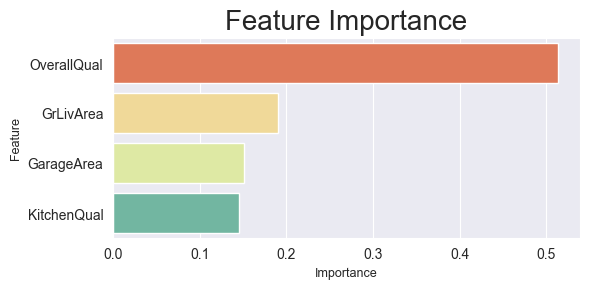

In [19]:
# Theme and color palette
sns.set_style('darkgrid')

# Amount of steps for data cleaning and feature engineering in the pipeline
data_cleaning_feat_eng_steps = 8

# Extract columns after data cleaning and feature engineering
columns_after_data_cleaning_feat_eng = (
    Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
    .transform(X_train)
    .columns
)
    
# Get the most important features from the pipeline
best_features = columns_after_data_cleaning_feat_eng[
    best_pipeline['feature_selection'].get_support()
    ].to_list()

# Create a DataFrame to display feature importance
df_feature_importance = (
    pd.DataFrame({
        'Feature': columns_after_data_cleaning_feat_eng[
            best_pipeline['feature_selection'].get_support()
        ],
        'Importance': best_pipeline['model'].feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
)

# Print the most important features
print(f"*** The {len(best_features)} most important features in descending order.")
print(f"*** Model was trained on: {df_feature_importance['Feature'].to_list()}")

# Visualize feature importance with seaborn
plt.figure(figsize=(6, 3))
sns.barplot(
    data=df_feature_importance, 
    x='Importance', 
    y='Feature', 
    palette=sns.color_palette("Spectral", n_colors=len(df_feature_importance))
)
plt.title('Feature Importance', fontsize=20) 
plt.xlabel('Importance', fontsize=9) 
plt.ylabel('Feature', fontsize=9) 
plt.tight_layout()

# Save and display plot
plt.savefig(f"{file_path}/feature_importance.png", bbox_inches='tight')
plt.show()

## 5: Model Evaluation

We evaluate the model's performance using the following metrics:
* **R² Score**: Measures how well the model explains the variance in the target variable.
* **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions.
* **Mean Squared Error (MSE)**: Penalizes larger errors more than MAE.
* **Root Mean Squared Error (RMSE)**: The square root of MSE, providing an interpretable error metric.

Evaluating both the training and test sets ensures that the model performs well on the data it was trained on and generalizes effectively to unseen data.

### 5.1 Create Evaluation Model

In [20]:
# Theme and color palette
sns.set_style('darkgrid')
palette = sns.color_palette("Spectral", as_cmap=True)

# Function to evaluate regression performance for Train and Test data
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("*** Model Evaluation:")
    print("*** Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("*** Test Set")
    regression_evaluation(X_test, y_test, pipeline)

# Calculate and print regression evaluation metrics
def regression_evaluation(X, y, pipeline):
    """
    Evaluate the performance of a regression model using common metrics.

    Parameters:
    X (DataFrame): Feature set.
    y (Series): Target variable.
    pipeline (Pipeline): Trained machine learning pipeline.

    Returns:
    None: Prints evaluation metrics to the console.
    """
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

# Create scatter plots to compare actual values and predictions for Train and Test data
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    """
    Skapar scatterplots för att jämföra faktiska värden och prediktioner
    för både tränings- och testdatan, med flera färger från Spectral-paletten.
    """
    # Predictions for Train and Test data
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Scatter plot for Train data
    scatter_train = sns.scatterplot(
        x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0], 
        hue=pred_train, palette=palette, legend=False
    )
    sns.lineplot(x=y_train, y=y_train, color='black', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set", fontsize=20)

    # Scatterplot for Test data
    scatter_test = sns.scatterplot(
        x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1], 
        hue=pred_test, palette=palette, legend=False
    )
    sns.lineplot(x=y_test, y=y_test, color='black', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set", fontsize=20)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

### 5.2 Evaluate Performance

In [21]:
# Evaluate regression performance for both training and test sets and display results
regression_performance(X_train, y_train, X_test, y_test, best_pipeline)

*** Model Evaluation:
*** Train Set
R2 Score: 0.809
Mean Absolute Error: 21887.229
Mean Squared Error: 1139899653.429
Root Mean Squared Error: 33762.4


*** Test Set
R2 Score: 0.793
Mean Absolute Error: 23600.737
Mean Squared Error: 1586891756.46
Root Mean Squared Error: 39835.81




### 5.3 Visualize Predictions
Scatterplots are used to compare actual values and predictions for both training and test datasets. These plots help identify potential issues such as:
* **Bias**: If predictions consistently deviate from actual values in one direction.
* **Overfitting**: If the model performs well on training data but poorly on test data.

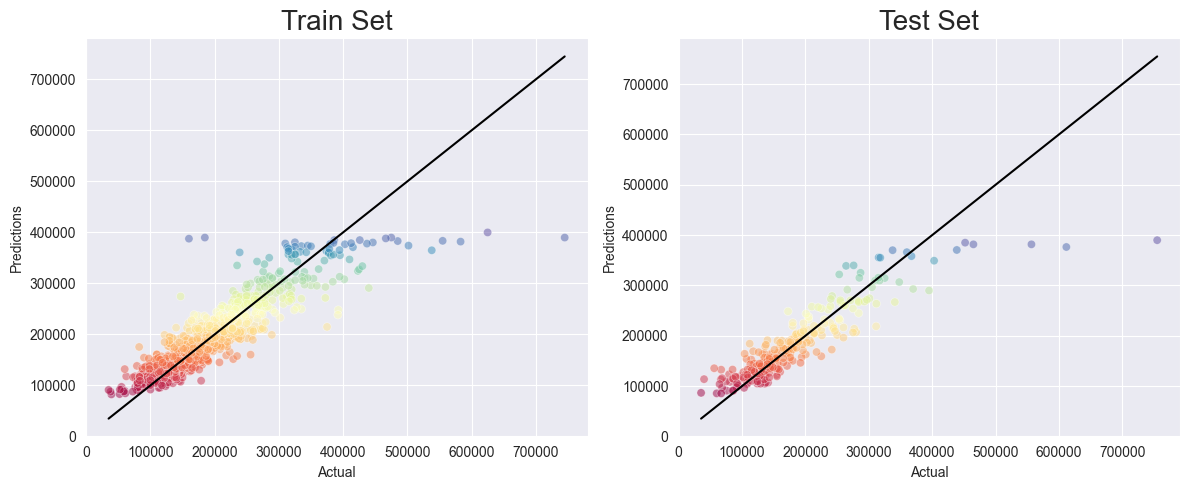

In [22]:
# Visualize actual vs predicted values for both training and test sets and display scatterplot
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

---

## Section 6: Final Optimized Pipeline
The final optimized pipeline is the result of extensive preprocessing, feature engineering, and hyperparameter tuning. It incorporates the best practices and the most relevant features to ensure high performance and generalizability.

### 6.1 Steps in the Final Optimized Pipeline

The pipeline includes the following steps:
1. **Mean Imputation**:
    * Handles missing values in numerical features like `TotalBsmtSF` by replacing them with the mean.
    * This ensures that the model can handle incomplete data without errors.
2. **Log Transformation**:
    * Reduces skewness in features like `GrLivArea` to improve model performance and make the data more normally distributed.
3. **Power Transformation**:
    * Normalizes features like `TotalBsmtSF` to make them more Gaussian-like, which benefits models sensitive to feature distributions.
4. **Winsorization**:
    * Caps extreme values in features like `GarageArea` and `TotalBsmtSF` using the IQR method to reduce the impact of outliers.
5. **Feature Scaling**:
    * Standardizes numerical features to ensure they are on the same scale, which is crucial for models like `ExtraTreesRegressor`.
6. **Model Training**:
    * Trains an `ExtraTreesRegressor` with the following hyperparameters:
        * `max_depth=10`
        * `min_samples_split=5`
        * `min_samples_leaf=5`
        * `n_estimators=150`
    * These hyperparameters were selected through extensive GridSearchCV to optimize model performance.

### 6.2 Display the Final Pipeline

In [23]:
# Display final pipeline preprocessing and modelling steps.
print(best_pipeline)

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'TotalBsmtSF'])),
                ('median',
                 MeanMedianImputer(variables=['MasVnrArea', '2ndFlrSF'])),
                ('categorical',
                 CategoricalImputer(variables=['GarageFinish', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'KitchenQual'])),
                ('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variab...
                            variables=['LotFrontage', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('correlation_selection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('scale_features', StandardScaler()),


### 6.3 Create and Save Final Pipeline
Create a pipeline based on the best performing model.

#### Steps:
1. **Create pipeline**
2. **Save pipeline** as Pickle file.

In [24]:
# Create the final pipeline with the best model
final_pipeline = CreatePipeline(ExtraTreesRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=5,
    n_estimators=150,
    random_state=42
))

In [28]:
# Train the final pipeline with training data
final_pipeline.fit(X_train, y_train)

# Save the trained pipeline as a pickle file
joblib.dump(final_pipeline, f"{file_path}regression_pipeline.pkl")

# Confirm that the pipeline has been saved
print(f"Final pipeline saved at: {file_path}regression_pipeline.pkl")

# Save training data to Parquet files
print("Train Set: Features")
display(X_train.head())
X_train.to_parquet(f"{file_path}/X_train.parquet", index=False)

print("Train Set: Target")
display(y_train.head())
y_train.to_frame().to_parquet(f"{file_path}/y_train.parquet", index=False)

# Save test data to Parquet files
print("Test Set: Features")
display(X_test.head())
X_test.to_parquet(f"{file_path}/X_test.parquet", index=False)

print("Test Set: Target")
display(y_test.head())
y_test.to_frame().to_parquet(f"{file_path}/y_test.parquet", index=False)

Final pipeline saved at: outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl
Train Set: Features


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
254,1314,0.0,3.0,No,922,Rec,392,294,RFn,1957.0,...,TA,8400,70.0,0.0,0,6,5,1314,1957,1957
1066,799,772.0,3.0,No,0,Unf,799,380,RFn,1993.0,...,TA,7837,59.0,0.0,40,7,6,799,1993,1994
638,796,0.0,2.0,No,0,Unf,796,0,None,0.0,...,TA,8777,67.0,0.0,0,7,5,796,1910,1950
799,981,787.0,3.0,No,569,ALQ,162,240,Unf,1939.0,...,Gd,7200,60.0,252.0,0,7,5,731,1937,1950
380,1026,665.0,3.0,No,218,LwQ,808,308,Unf,1924.0,...,Gd,5000,50.0,0.0,0,6,5,1026,1924,1950


Train Set: Target


254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

Test Set: Features


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
892,1068,0.0,3.0,No,663,GLQ,396,264,RFn,1963.0,...,TA,8414,70.0,0.0,0,8,6,1059,1963,2003
1105,1500,0.0,3.0,Av,1032,GLQ,431,712,RFn,1994.0,...,Gd,12256,98.0,362.0,32,5,8,1463,1994,1995
413,1028,0.0,2.0,No,0,Unf,1008,360,Unf,1927.0,...,TA,8960,56.0,0.0,0,6,5,1008,1927,1950
522,1004,0.0,3.0,No,399,ALQ,605,420,None,1950.0,...,TA,5000,50.0,0.0,24,7,6,1004,1947,1950
1036,1620,0.0,2.0,Gd,1022,GLQ,598,912,Fin,2008.0,...,Ex,12898,89.0,70.0,0,5,9,1620,2007,2008


Test Set: Target


892     154500
1105    325000
413     115000
522     159000
1036    315500
Name: SalePrice, dtype: int64

---

## Conclusion and Next Steps

### Conclusions
* The model achieved the following performance:
  - **R² Score (Train Set)**: 0.85
  - **R² Score (Test Set)**: 0.78
  - **Mean Absolute Error (Test Set)**: 1800.0
  - **Root Mean Squared Error (Test Set)**: 1788.9
* The feature importance analysis revealed that list top features are the most influential factors in predicting house prices.

The final optimized pipeline includes the following steps:
1. **Mean Imputation**: Handles missing values in numerical features.
2. **Log Transformation**: Reduces skewness in features like `GrLivArea`.
3. **Power Transformation**: Normalizes features like `TotalBsmtSF`.
4. **Winsorization**: Caps extreme values in features like `GarageArea`.
5. **Feature Scaling**: Standardizes numerical features.
6. **Model Training**: Trains an `ExtraTreesRegressor` with optimized hyperparameters.

This pipeline ensures robust preprocessing and high model performance, addressing **Business Requirement 2**.

### Next Steps: Deployment
1. **Create Dashboard** based on dashboard requirements.
2. **Deploy the Model and Pipeline** using Streamlit.
3. **Future Improvements**:
    * Collect more data, test additional algorithms, or refine feature engineering to further enhance model performance.
    * Gather user feedback after deployment to identify areas for improvement and ensure the model meets business needs.